# Self-organized criticality

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 8

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from thinkstats2 import Hist, Cdf

from matplotlib import rc
rc('animation', html='html5')

/home/megsaysrawr/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Sand pile

`Sand.py` contains an implementation of the sand pile model.

In [2]:
from Sand import SandPile, SandPileViewer

Here's a small example starting with two cells ready to topple.  `n` is the number of rows, `m` is the number of columns.

In [3]:
pile = SandPile(n=3, m=5, level=0)
pile.array[1, 1] = 4
pile.array[1, 3] = 4

a = pile.array
print(a)

[[0 0 0 0 0]
 [0 4 0 4 0]
 [0 0 0 0 0]]


To execute one step, first we find cells that are above the toppling threshold, `K`.

In [4]:
K = 3
toppling = a > K
print(toppling.astype(int))

[[0 0 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]]


Then we use `correlate2d` to make a copy of the update kernel around each toppling cell.

In [5]:
kernel = np.array([[0, 1, 0],
                   [1,-4, 1],
                   [0, 1, 0]], 
                  dtype=np.int32)

from scipy.signal import correlate2d

c = correlate2d(toppling, kernel, mode='same', boundary='fill', fillvalue=0)
print(c)

[[ 0  1  0  1  0]
 [ 1 -4  2 -4  1]
 [ 0  1  0  1  0]]


Finally, we add the result back into the array:

In [6]:
a += c
print(a)

[[0 1 0 1 0]
 [1 0 2 0 1]
 [0 1 0 1 0]]


Any grains that topple off the edge disappear.

## Animation

Let's look at a bigger pile, with `n=20`.  All cells are initialized to `level`, which is meant to be substantially bigger than `K`.

In [7]:
pile = SandPile(n=20, level=10)
print(pile.run())

(332, 53336)


The `run` function invokes `step` until no more cells topple and returns the number of time steps and the number of affected cells.

Now let's look at an animation, starting from this initialized pile.

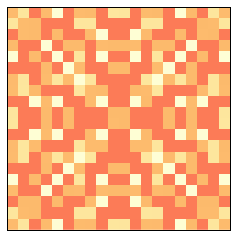

In [8]:
viewer = SandPileViewer(pile, drop_flag=True)
anim = viewer.animate(frames=100)

Starting with `level>K` produces all kinds of interesting patterns.

Each step of the animation drops a single grain at a random location and runs until no more cells topple.

Most avalanches are small, but some are very large.

In [9]:
anim

After a while, the pile looks pretty random.

Here's a plot of the number of cells toppled after each `step`.  

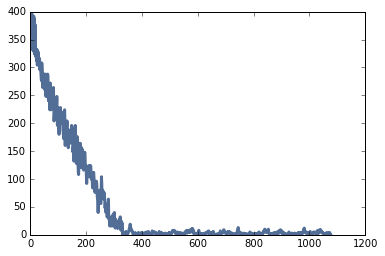

In [10]:
thinkplot.plot(pile.toppled_seq)

The following figure shows the progression of the pile from ordered to apparently random.

(332, 53336)


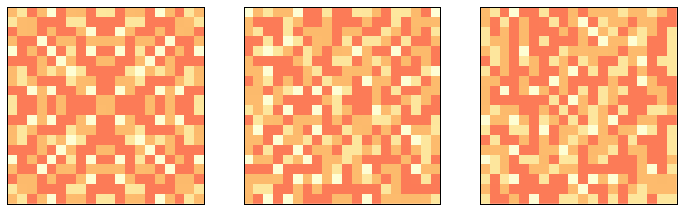

In [11]:
pile = SandPile(n=20, level=10)
print(pile.run())
viewer = SandPileViewer(pile)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
for i in range(200):
    viewer.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(200):
    viewer.step()
viewer.draw()

plt.savefig('chap08-1.pdf')

## Long tailed distributions

If the sand pile is in a critical state, we expect quantities like the duration of an avalanche, `T`, and the number of cells affected, `S`, to have long-tailed distributions.

Following Bak, Tang, and Wiesenseld, we start with a 50x50 array and plot the PMFs of `S` and `T` on a log-log scale.

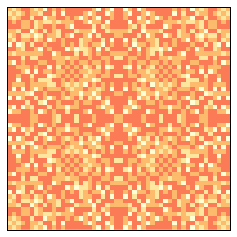

In [12]:
pile2 = SandPile(n=50, level=30)
pile2.run()
viewer = SandPileViewer(pile2)
viewer.draw()

Now we run the pile for many time steps and keep track of the durations and number of cells affected.

In [13]:
iters = 100000
%time res = [pile2.drop_and_run() for _ in range(iters)]

CPU times: user 2min 58s, sys: 103 ms, total: 2min 58s
Wall time: 2min 58s


And extract the results into two NumPy arrays.

In [14]:
T, S = np.transpose(res)

A large majority of drops have duration 1 and no toppled cells, so we'll filter those out.

In [15]:
T = T[T>1]
S = S[S>0]

The distributions of `T` and `S` have many small values and a few very large ones.

Here are the histograms on linear axes, showing only small values.

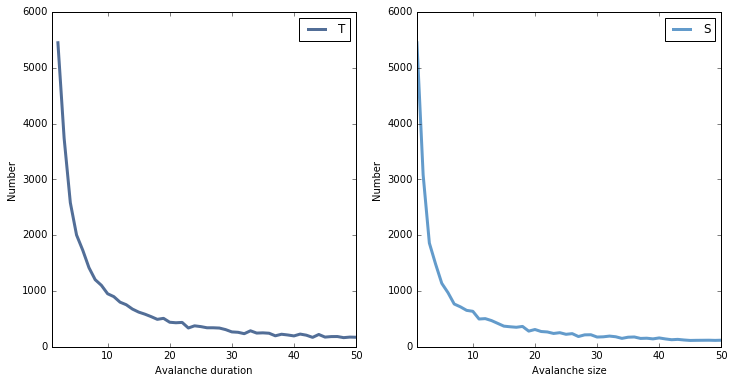

In [16]:
thinkplot.preplot(cols=2)

histT = Hist(T)
thinkplot.Pdf(histT, label='T')
thinkplot.config(xlabel='Avalanche duration',
                 ylabel='Number',
                 xlim=[1, 50], loc='upper right')

thinkplot.subplot(2)

histS = Hist(S)
thinkplot.Pdf(histS, label='S')
thinkplot.config(xlabel='Avalanche size',
                 ylabel='Number',
                 xlim=[1, 50])

plt.savefig('chap08-2.pdf')

To see whether these distributions follow a power law, we plot the histograms on a log-log scale.

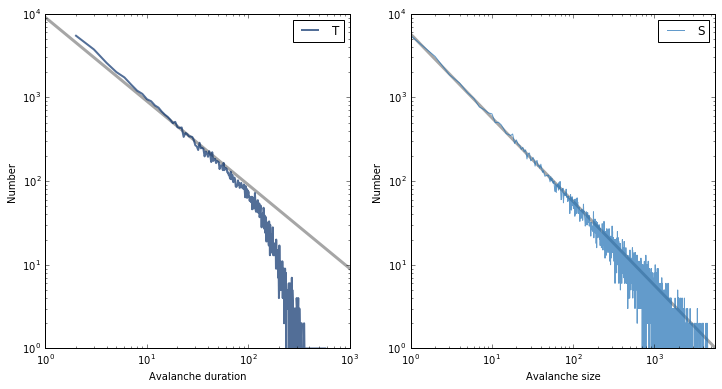

In [17]:
thinkplot.preplot(cols=2)

x = 9000
thinkplot.plot([1, x], [x, 1], color='gray', linewidth=3)
thinkplot.Pdf(histT, label='T', linewidth=2)
thinkplot.config(xlabel='Avalanche duration',
                 xlim=[1, 1000],
                 ylabel='Number',
                 xscale='log',
                 yscale='log',
                 loc='upper right')

thinkplot.subplot(2)

x = 5700
thinkplot.plot([1, x], [x, 1], color='gray', linewidth=3)
thinkplot.Pdf(histS, label='S', linewidth=1)
thinkplot.config(xlabel='Avalanche size',
                 xlim=[1, 5600],
                 ylabel='Number',
                 xscale='log',
                 yscale='log')

plt.savefig('chap08-3.pdf')

The gray line has slope -1.  The distribution of avalanche duration is approximately straight between 1 and 100, but then drops off.  The distribution of size follows a power law more closely and over a greater range, but it also seems to drop off for values above a few hundred.

**Exercise:** Try running the model longer to see if you can get a less noisy plot of the distributions of `T` and `S`.

## Fractals

If the sand pile is in a critical state, we expect to see fractal geometry.

To estimate the fractal dimension, I'll start with a bigger pile and a higher initial level.

In [18]:
pile3 = SandPile(n=131, level=22)
%time pile3.run()

CPU times: user 18.9 s, sys: 0 ns, total: 18.9 s
Wall time: 18.9 s


(28379, 211320220)

The initial state sure looks like a fractal.

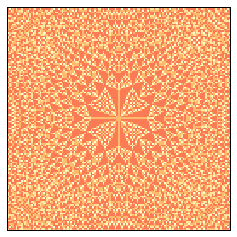

In [19]:
viewer3 = SandPileViewer(pile3)
viewer3.draw()

Since it contains four different levels (0, 1, 2, and 3), we can extract 4 binary patterns.

In [20]:
def draw_four(viewer, vals=range(4)):
    thinkplot.preplot(rows=2, cols=2)
    a = viewer.viewee.array
    
    for i, val in enumerate(vals):
        thinkplot.subplot(i+1)
        viewer.draw_array(a==vals[i], vmax=1)

Here's what they look like:

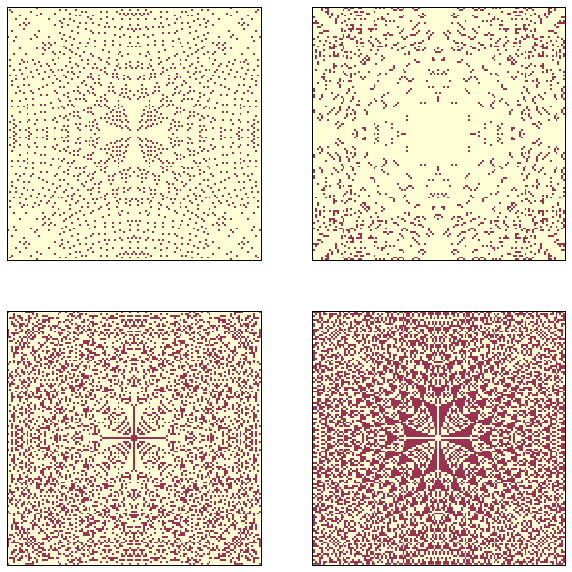

In [21]:
draw_four(viewer3)
plt.savefig('chap08-4.pdf')

Now we can apply a box-counting algorithm to each level.

`count_cells` starts with a single cell in the middle, gradually increases the size of the box, and counts the number of cells in each box.

In [22]:
def count_cells(a):
    """Counts the number of cells in boxes with increasing size.
    
    a: NumPy array
    
    returns: list of (i, i**2, cell count) tuples
    """
    n, m = a.shape
    end = min(n, m)
    
    res = []
    for i in range(1, end, 2):
        top = (n-i) // 2
        left = (m-i) // 2
        box = a[top:top+i, left:left+i]
        total = np.sum(box)
        res.append((i, i**2, total))
        
    return np.transpose(res)

`box_count` takes a pile and a value, extracts the cells that have the given value, calls `count_cells`, and estimates the fractal dimension.

If `plot` is `True`, it also generates a graph of cell count versus box size on a log-log scale.

In [23]:
from scipy.stats import linregress

def box_count(pile, val=0, plot=False):
    """Estimates the fractal dimension by box counting.
    
    pile: SandPile
    val: which value from the pile to count
    plot: boolean, whether to generate a plot
    
    returns: estimated fractal dimension
    """
    res = count_cells(pile.array==val)
    steps, steps2, cells = res
    
    # select the range where we have a nonzero number of cells
    legit = np.nonzero(cells)
    steps = steps[legit]
    steps2 = steps2[legit]
    cells = cells[legit]

    if plot:
        thinkplot.preplot(3)
        thinkplot.plot(steps, steps2, linestyle='dashed')
        thinkplot.plot(steps, cells, label='val=%d' % val)
        thinkplot.plot(steps, steps, linestyle='dashed')

        thinkplot.config(xscale='log', yscale='log',
                         xlim=[1, 200], loc='upper left',
                         xlabel='box size', ylabel='cell count')
    
    params = linregress(np.log(steps), np.log(cells))
    return params[0]

Finally `box_count_four` applies the box counting algorithm for each value in the sand pile.

In [24]:
def box_count_four(pile, vals=range(4)):
    """Applies box counting to each value in the pile.
    
    pile: SandPile
    vals: list of values to check
    """
    thinkplot.preplot(rows=2, cols=2)
    
    dims = []
    for i, val in enumerate(vals):
        thinkplot.subplot(i+1)
        dim = box_count(pile, val, plot=True)
        dims.append(dim)
        
    return dims

Here are the results:

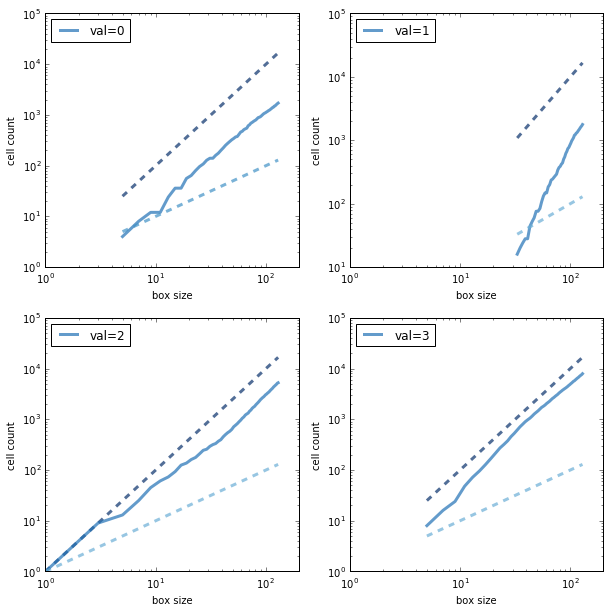

In [25]:
dims = box_count_four(pile3)
plt.savefig('chap08-5.pdf')

The lines are reasonably straight, which indicates that we are running the algorithm over a valid range of box sizes.  Here are the estimated slopes:

In [26]:
for i, dim in enumerate(dims):
    print('%d  %0.3f' % (i, dim))

0  1.871
1  3.502
2  1.781
3  2.084


The fractal dimension for values 0, 1, and 2 seems to be clearly non-integer, which indicates that the image is fractal.

Strictly, the fractal dimension for value 3 is indistinguishable from 2, but given the results for the other values, the apparent curvature of the line, and the appearance of the pattern, it seems likely that it is also fractal. 

**Exercise:**  Choose a different value of `n` and/or `level` and run this analysis again.  Are the estimated fractal dimensions consistent?

## Spectral density

Suppose the sandpile made a little click each time a cell toppled.  What would it sound like?

`toppled_seq` contains the number of cells that toppled during each time step.  We can use Welch's algorithm to estimate its [power spectral density](https://en.wikipedia.org/wiki/Spectral_density).

In [27]:
signal = pile2.toppled_seq
len(signal)

1432441

In [28]:
from scipy.signal import welch

nperseg = 2048
freqs, powers = welch(signal, nperseg=nperseg, fs=nperseg)

And here's what it looks like.

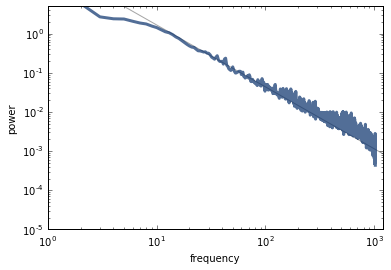

In [29]:
x = nperseg
ys = np.array([x**1.58, 1]) / 2.7e3
thinkplot.plot([1, x], ys, color='gray', linewidth=1)

thinkplot.plot(freqs, powers)
thinkplot.config(xlabel='frequency', xscale='log', xlim=[1, 1200],
                 ylabel='power', yscale='log', ylim=[1e-5, 5])

plt.savefig('chap08-6.pdf')

The slope of the line is -1.58, which indicates that this spectrum is pink noise with parameter $\beta=1.58$.

**Exercise:**  Choose a different value of `nperseg` and run this analysis again.  What are the pros and cons of larger segment lengths?  Modify the code to run the model longer and see if you can get a less noisy estimate of the spectrum.

## Exercises

**Exercise:** To test whether the distributions of `T` and `S` are heavy-tailed, we plotted their histograms on a log-log scale, which is what Bak, Tang and Wiesenfeld show in their paper.  But as we saw in Chapter 4, this visualization can obscure the shape of the distribution.  Using the same data, make a plot that shows the CDFs of `S` and `T`.  What can you say about the shape of these distributions?  Do they follow a power law?  Are they heavy tailed?

You might find it helpful to plot the CDFs on a log-x scale and on a log-log scale.

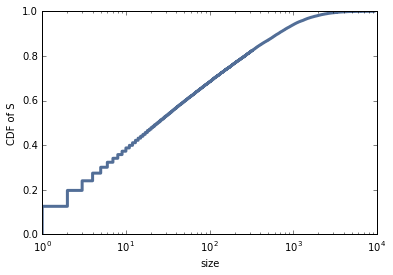

In [30]:
# Solution goes here
#CDF of S, log-x scale
cdfS = Cdf(S)
thinkplot.Cdf(cdfS)
thinkplot.config(xlabel='size', ylabel='CDF of S', xscale='log')

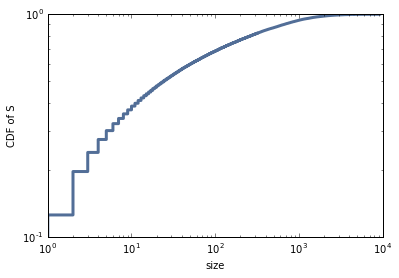

In [31]:
# Solution goes here
#CDF of S, log-log scale
cdfS = Cdf(S)
thinkplot.Cdf(cdfS)
thinkplot.config(xlabel='size', ylabel='CDF of S', xscale='log', yscale='log')

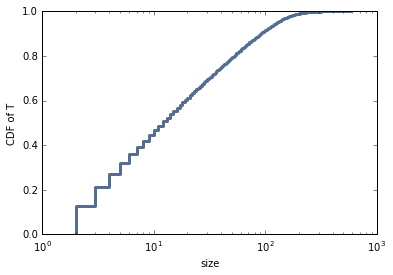

In [32]:
# Solution goes here
#CDF of T, log-x scale
cdfT = Cdf(T)
thinkplot.Cdf(cdfT)
thinkplot.config(xlabel='size', ylabel='CDF of T', xscale='log')

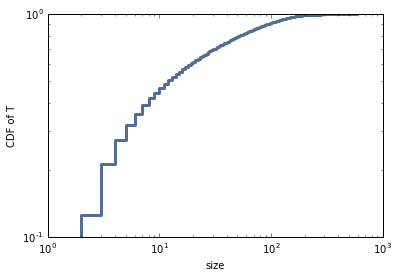

In [33]:
# Solution goes here
#CDF of T, log-log scale
cdfT = Cdf(T)
thinkplot.Cdf(cdfT)
thinkplot.config(xlabel='size', ylabel='CDF of T', xscale='log', yscale='log')

#### Solution goes here
For both S and T, the log-x scale graphs have "stair steps" that get progressively smaller and then turn into nearly a straight line.

Again, for both S and T, the log-log scale graphs have the same "stair step" structure, but instead of flattening out, they follow a slight upward curve.

Due to the (almost) straight lines on the log-x scale graphs, I would say that these would be more likely to have be heavy tailed and follow the power law.

**Exercise:** In Section 8.5 we showed that the initial configuration of the sand pile model produces fractal patterns.  But after we drop a large number of random grains, the patterns look more random.

Starting with the example in Section 8.5, run the sand pile model for a while and then compute fractal dimensions for each of the 4 levels.  Is the sand pile model fractal in steady state?

In [34]:
# Solution goes here
# The example in section 8.5 starts with pile 3, like so (renamed to pile3b)
pile3b = SandPile(n=131, level=22)
pile3b.run()

(28379, 211320220)

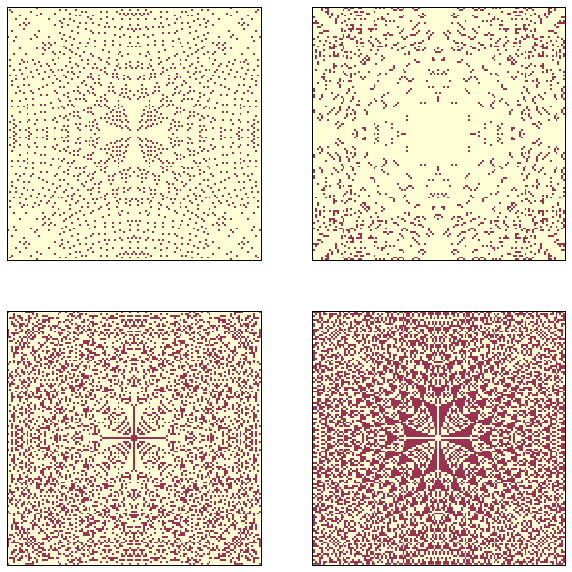

In [35]:
# Solution goes here
viewer3b = SandPileViewer(pile3b)
draw_four(viewer3b)

#### Solution goes here
I would say that those graphs look pretty fractal!

The bottom right appears to be the most defined, then bottom left, then top left, then top right.

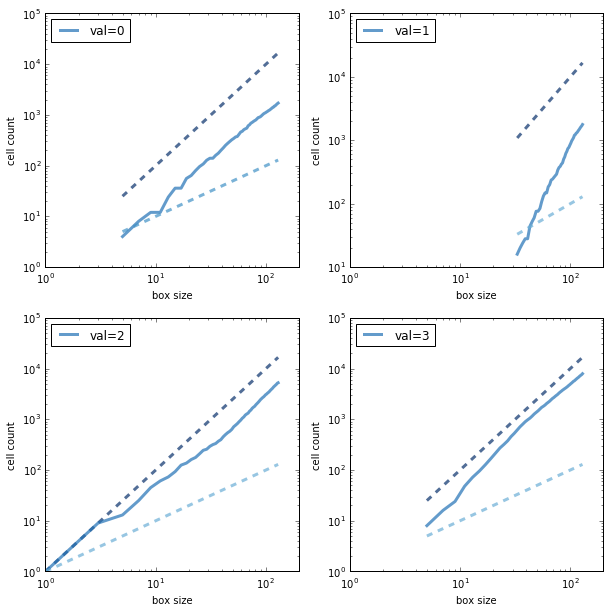

In [36]:
# Solution goes here
count = box_count_four(pile3b)

#### Solution goes here
The box counting and display of fractal values confirmed my hypothesis regarding which graph was most fractal.

The bottom right box fits within the dotted line bounds of slope 1 and 2 the best, then the bottom left, then top left, then top right.

I would say that yes, the sand model appears to be fractal after it has settled in its steady state model.

In [37]:
# Solution goes here
# Drop the sand, and RUNNNNN!!! (This doesn't always get to run full out, but it did a few times, I promise.)
iters = 10000
for x in range(iters):
    pile3b.drop_and_run()

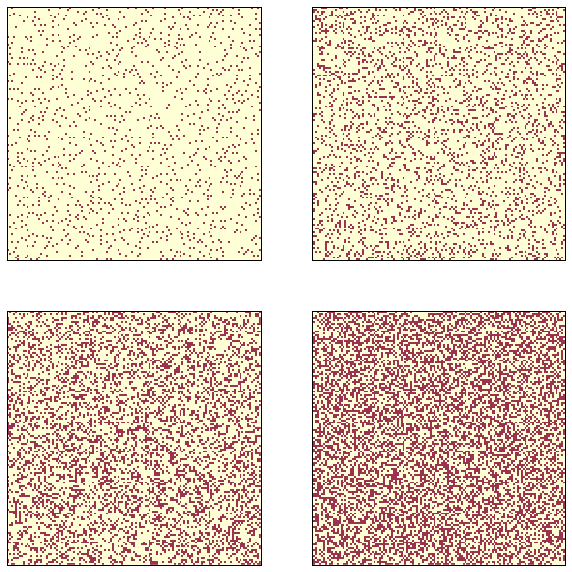

In [38]:
draw_four(viewer3b)     # running drop and run on pile3b overwrote the original pile3b
                        # so viewer3b is also overwritten to the new pile3b data

#### Solution goes here
The fractal patterns have started to disperse into more random formations, as expected.

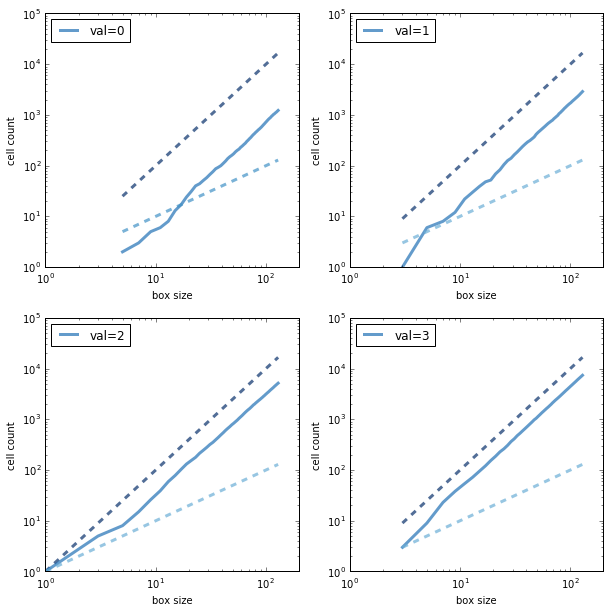

In [39]:
count = box_count_four(pile3b)

#### Solution goes here
The fractal values are starting to escape the bounding lines of slope 1 and 2. the bottom left graph fits most exactly, and then the bottom right, top right, and finally the top left, which is about 1/4 non-fractal (at the beginning) and 3/4 fractal (at the end).

In [40]:
# Solution goes here
for i, dim in enumerate(dims):
    print('Graph %d has a fractal value of: %0.3f' % (i, dim))

Graph 0 has a fractal value of: 1.871
Graph 1 has a fractal value of: 3.502
Graph 2 has a fractal value of: 1.781
Graph 3 has a fractal value of: 2.084
